In [1]:
import pylab as plt
import numpy as np
import cv2
import mptracker as mpt
from mptracker import sobel3x3
from glob import glob 
import os
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

files = np.sort(glob('../*.tif'))

filenames = [f for f in files]
target =  filenames[0]
print target
imgstack = mpt.TiffFileSequence(target)


../161109164149_CA055_lgnmov_0000.tif


In [7]:
clahe = cv2.createCLAHE(7,(10,10))
ii = 90
img = clahe.apply(imgstack.get(ii))
fig = plt.figure(figsize = [10,10])


mag,imgx,imgy = sobel3x3(img)

def radial_transform(img, radii = None, alpha = 2., 
                     stdFactor = 0.1, bright = True, dark = True):
    (nrows, ncols) = img.shape
    radii = None
    if radii is None:
        radii = np.linspace(nrows/2000.,nrows/8.,3)
        
    mag,gx,gy = sobel3x3(img)
    
    offset = np.array([np.ceil(np.max(radii[:]))]*2).astype(int)
    
    filtered = np.zeros((img.shape + 2*offset).astype(int))
    print filtered.shape
    print img.shape
    S = np.zeros(np.array([len(radii), filtered.shape[0], filtered.shape[1]]).astype(int))
    

    O_n = np.zeros_like(filtered)
    M_n = np.zeros_like(filtered)
    for radiusIndex,n in enumerate(radii):
        print radiusIndex
        O_n[:] = 0
        M_n[:] = 0
        for i in np.arange(nrows):
            for j in np.arange(ncols):                
                p = np.array([i,j],dtype=int)
                g = np.array([gx[i,j],gy[i,j]],dtype=int)
                gnorm = np.sqrt(np.dot(g,g.T))
                if (gnorm > 0):
                    gp = np.round((g/gnorm) * n).astype(int)
                    if bright:
                        ppve = p + gp
                        ppve += offset;
                        O_n[ppve[0], ppve[1]] += 1
                        M_n[ppve[0], ppve[1]] += gnorm
                    if (dark):
                        pnve = p - gp
                        pnve += offset
                        O_n[pnve[0], pnve[1]] -= 1
                        M_n[pnve[0], pnve[1]] -= gnorm
        O_n = np.abs(O_n)
        O_n /= np.max(O_n)
        M_n = np.abs(M_n)
        M_n /= np.max(M_n)
        S_n = np.power(O_n,alpha) * M_n;
        ksize = float(np.ceil(n/2))
        if np.mod(ksize,2) == 0:
            ksize -= 1
        ksize = int(ksize)
        S[radiusIndex,:,:] = cv2.GaussianBlur(S_n,
                                              (ksize,ksize), 
                                              n*stdFactor)
        
    filtered = np.sum(S, axis=0)
    filtered = filtered[offset[0]:-offset[1], offset[0]:-offset[1]]
    return filtered
                        
# plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
# plt.title('Original'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,2),plt.imshow(mag,cmap = 'hot')
# plt.title('mag'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,3),plt.imshow(imgx,cmap = 'hot')
# plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
# plt.subplot(2,2,4),plt.imshow(imgy,cmap = 'hot')
# plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

# plt.show()

In [42]:
im = img.copy()
radii = None
alpha = None
beta = None
feedback=None
    
if beta is None: beta = 0
if feedback is None: feedback = 0

(rows, cols) = img.shape
radii = None
if radii is None:
    radii = np.linspace(rows/2000.,rows/8.,6).astype(int)    
mag,imgx,imgy = sobel3x3(im,ksize=1)

# Normalise gradient values so that [imgx imgy] form unit 
# direction vectors.
imgx = imgx/mag
imgy = imgy/mag
S = np.zeros((rows,cols,len(radii)))  # Symmetry matrix
So = np.zeros((rows,cols,len(radii))) # Orientation only symmetry matrix    
(y, x) = np.mgrid[0:rows, 0:cols]   # grid
M = np.zeros((rows,cols))  # Magnitude projection image
O = np.zeros((rows,cols))  # Orientation projection image    
for n in radii:
    M[:] = 0
    O[:] = 0
    # Coordinates of 'positively' and 'negatively' affected pixels
    posx = x + np.round(n*imgx);
    posy = y + np.round(n*imgy);

    negx = x - np.round(n*imgx);
    negy = y - np.round(n*imgy);

    # Clamp coordinate values to range [1 rows 1 cols]
    posx[posx<0]    = 0;
    posx[posx>cols-1] = cols-1;
    posy[posy<0]    = 1;
    posy[posy>rows-1] = rows-1;

    negx[negx<0]    = 0;
    negx[negx>cols-1] = cols-1;
    negy[negy<0]    = 0;
    negy[negy>rows-1] = rows-1;
    
    I = np.ravel_multi_index(np.array([posy.flatten(),posx.flatten()]).astype(np.int64),im.shape)
    
#     for pi,pj,ni,nj in zip(posy.flatten(),posx.flatten(),negy.flatten(),negx.flatten()):
#         O[pi,pj] += 1.
#         O[ni,nj] -= 1.
# #     def accum_np(accmap, a, func=np.sum):
#         indices = np.where(np.ediff1d(accmap, to_begin=[1],
#                                   to_end=[1]))[0]
#         vals = np.zeros(len(indices) - 1)
#         for i in xrange(len(indices) - 1):
#             vals[i] = func(a[indices[i]:indices[i+1]])
#         return vals
    
    #         I = sub2ind( [rows,cols], posy, posx);
    
    #O[:] = accum_np( I, np.ones_like(I), np.sum)
#         M(:) = accumarray( I(:), mag(:), [prod([rows,cols]),1], @sum);
#         I(:) = sub2ind( [rows,cols], negy, negx);
#         O(:) = O(:) - accumarray( I(:), ones(size(I(:))), [prod([rows,cols]),1], @sum);
#         M(:) = M(:) - accumarray( I(:), mag(:), [prod([rows,cols]),1], @sum);
        
#         % Clamp Orientation projection matrix values to a maximum of 
#         % +/-kappa,  but first set the normalization parameter kappa to the
#         % values suggested by Loy and Zelinski
#         if n == 1, kappa = 8; else kappa = 9.9; end
        
#         O(O >  kappa) =  kappa;  
#         O(O < -kappa) = -kappa;  
        
#         % Unsmoothed symmetry measure at this radius value
#         F = M./kappa .* (abs(O)/kappa).^alpha;
#         Fo = sign(O) .* (abs(O)/kappa).^alpha;   % Orientation only based measure
        
#         % Smooth and spread the symmetry measure with a Gaussian proportional to
#         % n.  Also scale the smoothed result by n so that large scales do not
#         % lose their relative weighting.
#         S(:,:,n==radii) = gaussfilt(F,  0.25*n) * n;
#         So(:,:,n==radii) = gaussfilt(Fo, 0.25*n) * n;  

In [29]:
@jit(target='cpu',nogil=True)
def radial_transform_core(O,M,mag,posx,posy,negx,negy,kappa,F,alpha,ntiles,tile):
    rows,cols = mag.shape
    tile_size = rows / n_tiles;
    rstart = (tile) * tile_size;
    if(tile == n_tiles-1):
        rend = rows
    else:
        rend = (tile+1) * tile_size - 1;
    cstart = 0;
    cend = cols;
    for r in xrange(rstart,rend):
        for c in xrange(cstart,cend):
#            index = r*cols + c
            posx_ = round(posx[r,c])
            posy_ = round(posy[r,c])
            negx_ = round(negx[r,c])
            negy_ = round(negy[r,c])

            if ((posx_ < 0) or (posx_ > cols-1) or 
                (posy_ < 0) or (posy_ > rows-1) or
                (negx_ < 0) or (negx_ > cols-1) or
                (negy_ < 0) or (negy_ > rows-1)):
                continue
            if (posx_ < 0): posx_ = 0
            if (posx_ > cols-1): posx_ = cols-1
            if (posy_ < 0): posy_ = 0
            if (posy_ > rows-1): posy_ = rows-1
            if (negx_ < 0): negx_ = 0
            if (negx_ > cols-1): negx_ = cols-1
            if (negy_ < 0): negy_ = 0
            if (negy_ > rows-1): negy_ = rows-1
            #pos_index = posy_*cols + posx_
            #neg_index = negy_*cols + negx_
            O[posy_,posx_] += 1.0
            O[posy_,posx_] -= 1.0

            M[posy_,posx_] += mag[r,c]
            M[posy_,posx_] -= mag[r,c]
    for r in xrange(rstart, rend):
        for c in xrange(cstart, cend):
            O_ = abs(O[r,c]);
            if (O_ > kappa): O_ = kappa
            F[r,c] = M[r,c]/kappa * pow(O_/kappa, alpha);
    return F

im = img.copy()
radii = None
alpha = 10
beta = None
feedback=None
    
if beta is None: beta = 0
if feedback is None: feedback = 0

(rows, cols) = img.shape
radii = None
if radii is None:
    radii = np.linspace(rows/2000.,rows/8.,6).astype(int)    
mag,imgx,imgy = sobel3x3(im,ksize=1)

# Normalise gradient values so that [imgx imgy] form unit 
# direction vectors.
imgx = imgx/mag
imgy = imgy/mag
S = np.zeros((rows,cols,len(radii)))  # Symmetry matrix
So = np.zeros((rows,cols,len(radii))) # Orientation only symmetry matrix    
(y, x) = np.mgrid[0:rows, 0:cols]   # grid
M = np.zeros((rows,cols))  # Magnitude projection image
O = np.zeros((rows,cols))  # Orientation projection image   
F = np.zeros((rows,cols)) 

for r in range(len(radii)):
        n = radii[r]
        # Coordinates of 'positively' and 'negatively' affected pixels
        posx = x + n * imgx
        posy = y + n * imgy
        negx = x - n * imgx
        negy = y - n * imgy
        # Clamp Orientation projection matrix values to a maximum of
        # +/-kappa,  but first set the normalization parameter kappa to the
        # values suggested by Loy and Zelinski
        kappa = 9.9
        if n == 1:
            kappa = 8
        # Form the orientation and magnitude projection matrices
        ntiles = 1
        tile = 0
        print r
        F = radial_transform_core(O,M,mag,
                              posx.astype(int),posy.astype(int),
                              negx.astype(int),negy.astype(int),
                              kappa,F,alpha,ntiles,tile)
        
        width = np.round(0.8 * n)
        if np.mod(width, 2) == 0:
            width += 1

0


/users/joao/local/conda/envs/pycuda/lib/python2.7/site-packages/ipykernel/__main__.py:93: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
2
3
4
5


<IPython.core.display.Javascript object>


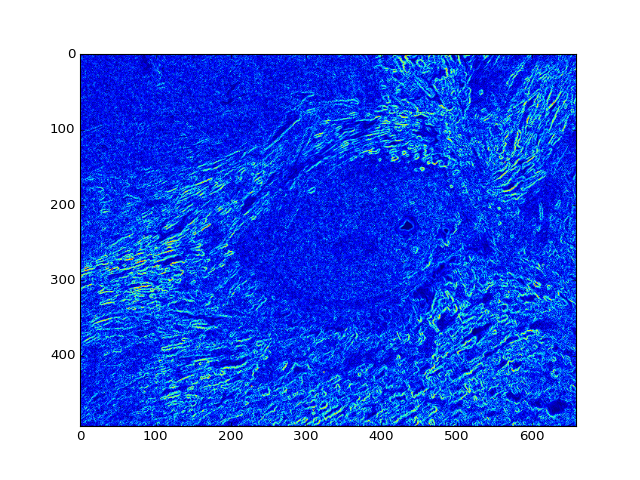

In [19]:
%matplotlib notebook
clahe = cv2.createCLAHE(7,(10,10))
ii = 0
img = clahe.apply(imgstack.get(ii))

mag,dx,dy = sobel3x3(img,ksize=1)
dx /= mag
dy /= mag
nrows,ncols = img.shape
radii = None
if radii is None:
    radii = np.linspace(nrows/2000.,nrows/8.,6).astype(int)
S = np.zeros((nrows,ncols,len(radii)))  # Symmetry matrix
So = np.zeros((nrows,ncols,len(radii))) # Orientation only symmetry matrix    
(y, x) = np.mgrid[0:nrows, 0:ncols]   # grid
M = np.zeros((nrows,ncols))  # Magnitude projection image
O = np.zeros((nrows,ncols))  # Orientation projection image   
F = np.zeros((nrows,ncols)) 

plt.figure()
plt.imshow(mag)

Allocated GPU arrays (block = (32, 32, 1), grid = (32, 32, 1)).


<IPython.core.display.Javascript object>


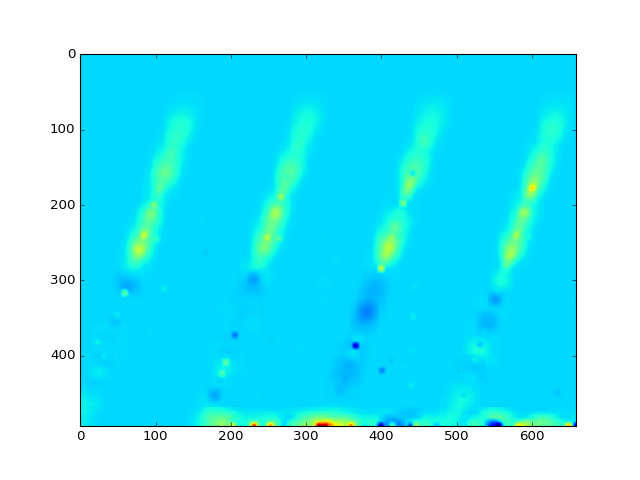

In [33]:
# PYCUDA!

clahe = cv2.createCLAHE(7,(10,10))
ii = 0
img = clahe.apply(imgstack.get(ii))
def cuda_radial_symmetry_transform(img, radii = None,alpha = 10., blocksize=16,dtype = np.float32):

    # Gradients and sobel magnitude
    mag,dx,dy = sobel3x3(img,ksize=1)
    dx /= mag
    dy /= mag

    # Initialize output and buffers
    nrows,ncols = mag.shape
    iw,ih = nrows,ncols
    (y, x) = np.mgrid[0:iw, 0:ih]   # grid
    radii = None
    if radii is None:
        radii = np.linspace(nrows/2000.,nrows/8.,6).astype(np.int32)

    mag = mag.astype(dtype)
    S = np.zeros_like(mag)
    F = np.zeros_like(S)
    zero = np.zeros_like(S)

    posx = np.zeros_like(mag,dtype=np.int32)
    posy = np.zeros_like(posx,dtype=np.int32)
    negx = np.zeros_like(posx,dtype=np.int32)
    negy = np.zeros_like(posx,dtype=np.int32)
    # GPU initialize
    # radial symmetry transform code
    code = """
    __global__ void gpu_radial_symmetry_step1(int *posx, int *posy, int *negx, int *negy,float *mag,float *O,float *M, float *F,float alpha,float kappa, int iw, int ih) {
        int i = blockIdx.x * blockDim.x + threadIdx.x;
        int j = blockIdx.y * blockDim.y + threadIdx.y;
        if (i >= iw  || j >= ih) return;
        int idx = j * iw + i;
        // fast radial symmetry transform 
        int posx_ = posx[idx];
        int posy_ = posy[idx];
        int negx_ = negx[idx];
        int negy_ = negy[idx];
        if(posx_ < 0) posx_ = 0;
        if(posx_ > iw-1) posx_ = iw-1;
        if(posy_ < 0) posy_ = 0;
        if(posy_ > ih-1) posy_ = ih-1;
        if(negx_ < 0) negx_ = 0;
        if(negx_ > iw-1) negx_ = iw-1;
        if(negy_ < 0) negy_ = 0;
        if(negy_ > ih-1) negy_ = ih-1;
        int pos_idx = (int)posx_ * iw + (int)posy_;
        int neg_idx = (int)negx_ * iw + (int)negy_;
        
        atomicAdd(&O[pos_idx], 1.0);
        atomicAdd(&O[neg_idx], (float) -1.0);
        atomicAdd(&M[pos_idx],(float) mag[idx]);
        atomicAdd(&M[neg_idx],(float) -1.0*mag[idx]);
        __syncthreads();
        float O_ = (float) abs(O[idx]);
        if (O_ > kappa) O_ = (float) kappa;
        float val = M[idx]/kappa * pow(O_/kappa,alpha);
        F[idx] = val;

    }

    //__global__ void gpu_radial_symmetry_step2(float *O, float *M, float *F, float alpha, float kappa, int iw, int ih) {
    //    int i = blockIdx.x * blockDim.x + threadIdx.x;
    //    int j = blockIdx.y * blockDim.y + threadIdx.y;
    //    if (i >= iw  || j >= ih ) return;
    //    int idx = j * iw + i;
    //    // fast radial symmetry transform step 2
    //    float O_ = (float) abs(O[idx]);
    //    if (O_ > kappa) O_ = (float) kappa;
    //    F[idx] = (float) M[idx]/kappa * pow(O_/kappa,alpha);
    //}
    """

    dev = cuda.Device(0)
    dev.make_context()
    prg = SourceModule(code)
    frst_step1 = prg.get_function("gpu_radial_symmetry_step1")
    
    mag_gpu = gpuarray.to_gpu(mag)
    O_gpu = gpuarray.zeros_like(mag_gpu)
    M_gpu = gpuarray.zeros_like(mag_gpu)
    F_gpu = gpuarray.zeros_like(mag_gpu)
    
    posx_gpu = gpuarray.to_gpu(posx)
    posy_gpu = gpuarray.zeros_like(posx_gpu)
    negx_gpu = gpuarray.zeros_like(posx_gpu)
    negy_gpu = gpuarray.zeros_like(posx_gpu)
    
    block = (blocksize,blocksize,1)
    grid = ((iw+blocksize+1)/blocksize,(ih+blocksize+1)/blocksize,1)

#    frst_step2 = prg.get_function("gpu_radial_symmetry_step2")

    print('Allocated GPU arrays (block = {0}, grid = {0}).'.format(block,grid))
    for r,n in enumerate(radii):
        # Coordinates of 'positively' and 'negatively' affected pixels
        posx = np.round(x + n * dx).astype(np.int32)
        posy = np.round(y + n * dy).astype(np.int32)
        negx = np.round(x - n * dx).astype(np.int32)
        negy = np.round(y - n * dy).astype(np.int32)

        kappa = 9.9
        if n == 1:
            kappa = 8

        posx_gpu = gpuarray.to_gpu(posx)
        posy_gpu = gpuarray.to_gpu(posy)
        negx_gpu = gpuarray.to_gpu(negx)
        negy_gpu = gpuarray.to_gpu(negy)
        
        
        O_gpu = gpuarray.to_gpu(zero)
        M_gpu = gpuarray.to_gpu(zero)
        F_gpu = gpuarray.to_gpu(zero)
        
        frst_step1(posy_gpu,
                   posx_gpu,
                   negy_gpu,
                   negx_gpu,
                   mag_gpu,
                   O_gpu,
                   M_gpu,
                   F_gpu,
                   np.float32(alpha),
                   np.float32(kappa),
                   np.int32(iw),
                   np.int32(ih),
                   block=block, grid=grid)
        F = F_gpu.get()
        w = int(np.round(0.8*n))
        if np.mod(w,2) == 0:
            w += 1
        S += cv2.GaussianBlur(F,
                             (w,w), 
                             int(n*0.25))
    del mag_gpu
    del O_gpu
    del M_gpu
    del F_gpu
    del posx_gpu
    del posy_gpu
    del negx_gpu
    del negy_gpu
    return S
import time
tstart = time.time()
S = cuda_radial_symmetry_transform(img,blocksize=32)
%matplotlib notebook

plt.imshow(S,cmap='jet');


In [26]:
S


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

NameError: name 'negy' is not defined